In [2]:
%pip install edit_distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import edit_distance
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras import layers, models

In [18]:
target1 = 'CCATAGAGAGGTTATCCGCTCA'
target3 = 'TTTGATCTGAAATATTCAGGTC'
target1_prefix = 'GGGAATGGATCCACATCTACGAATTCGTA'
target1_suffix = 'CCGAGATCGGAAGAGCACACGT'
target3_prefix = 'GGGAATGGATCCACATCTACGAATTCGTT'
target3_suffix = 'TGCAGATCGGAAGAGCACACGT'

In [19]:
PATH1 = 'target1.csv'
PATH3 = 'target3.csv'
df1 = pd.read_csv(PATH1)
df3 = pd.read_csv(PATH3)

In [20]:
df1.head()

,sequence,structure,mfe,ABA_normalized
0,GGGAATGGATCCACATCTACGAATTCGTACCATAGAGAGGTTTAGG...,.........(((..((((.((...(((((((.......)))....)...,-10.600000,0.628832
1,GGGAATGGATCCACATCTACGAATTCGTACCATAGAAGGTTATCCG...,((((.(((((...(.((((((....))).....))).)...)))))...,-14.100000,0.109211
2,GGGAATGGATCCACATCTACGAATTCGTACCATAGAGAGGTTTATC...,((((.((((((....((((((....))).....)))..))))))))...,-19.299999,0.462700
3,GGGAATGGATCCACATCTACGAATTCGTACCATAGAAGGTTATCCG...,.((.((((((.(........).)))))).))......((....))(...,-11.300000,0.277148
4,GGGAATGGATCCACATCTACGAATTCGTACGCATAGAGAGGTTATC...,......((((((...((((((........))..))))..))..)))...,-14.400000,0.349502


In [136]:
mt = target1_prefix + target1 + target1_suffix
seq = 'GGGAATGGATCCACATCTACGAATTCGTACCATAGAGAGGTTTAGGCGACACCGAGATCGGAAGAGCACACGT'
print (len(seq[29:-22]))
print (get_diff(target1, seq[29:-22]))
print (seq[29:-22])
print (target1)

22
[(13, 'delete'), (15, 'replace', 'A'), (16, 'replace', 'G'), (19, 'insert', 'G'), (19, 'replace', 'A')]
CCATAGAGAGGTTTAGGCGACA
CCATAGAGAGGTTATCCGCTCA


In [142]:
#This function recovers the sequence of changes (insertions/deletions/replacements)
#from the perfect sequence to the target sequence
def get_diff(perfect, x):
    output = []
    sm = edit_distance.SequenceMatcher(a=perfect, b=x)
    for row in sm.get_opcodes():
        if row[0] == "equal":
            continue
        elif row[0] == "insert":
            output.append((row[1], "insert", x[row[3]]))
        elif row[0] == "delete":
            output.append((row[1], "delete"))
        else:
            output.append((row[1], "replace", x[row[3]]))
    return output



# want to create a value mapping table of the changes
# the structure goes like this:
# [(index, i, A), (index, i, C), (index, i, G), (index, i  T),
#  (index, r, A), (index, r, C), (index, r, G), (index, r, T), (index, d)]
# index is the position on the rna, i is insertion, r is replacement, d is deletion,
# In the future we can try to have a way to combine these variables
def get_action(coord):
    if (coord % 9) == 0:
        return "INS A"
    if (coord % 9) == 1:
        return "INS C"
    if (coord % 9) == 2:
        return "INS G"
    if (coord % 9) == 3:
        return "INS T"
    if (coord % 9) == 4:
        return "REP A"
    if (coord % 9) == 5:
        return "REP C"
    if (coord % 9) == 6:
        return "REP G"
    if (coord % 9) == 7:
        return "REP T"
    if (coord % 9) == 8:
        return "DEL"
    

def get_position(coord):
    if len(coord) == 2:
        return coord[0]*9+8
    elif coord[1] == 'insert' and coord[2] == 'A':
        return coord[0]*9
    elif coord[1] == 'insert' and coord[2] == 'C':
        return coord[0]*9 + 1
    elif coord[1] == 'insert' and coord[2] == 'G':
        return coord[0]*9 + 2
    elif coord[1] == 'insert' and coord[2] == 'T':
        return coord[0]*9 + 3
    elif coord[1] == 'replace' and coord[2] == 'A':
        return coord[0]*9 + 4
    elif coord[1] == 'replace' and coord[2] == 'C':
        return coord[0]*9 + 5
    elif coord[1] == 'replace' and coord[2] == 'G':
        return coord[0]*9 + 6
    elif coord[1] == 'replace' and coord[2] == 'T':
        return coord[0]*9 + 7
    else:
        print ("INCORRECT COORDINATE")
        return -1

#Plots detailed results
def display(predicted, actual, title="Predicted vs Actual", ylabel="Fit (ABA)", xlabel="Measured (ABA)"):
    x,y = actual,predicted
    
    
    
    # definitions for the axes
    left, width = 0.02, 0.65
    bottom, height = 0.2, 0.65
    spacing = 0.02


    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.1]
    rect_histy = [left + width + spacing, bottom, 0.1, height]

    # start with a rectangular Figure
    plt.figure(figsize=(8, 8))
    #plt.title("Predicted vs Expected ABA for Linear Regression Model")



    ax_scatter = plt.axes(rect_scatter)
    ax_scatter.tick_params(direction='in', top=True, right=True)
    ax_histx = plt.axes(rect_histx)
    ax_histx.tick_params(direction='in', labelbottom=False)
    ax_histy = plt.axes(rect_histy)
    ax_histy.tick_params(direction='in', labelleft=False)

    # the scatter plot:
    #ax_scatter.scatter(predicted, actual)
    ax_scatter.hexbin(x, y, edgecolors='none', gridsize=75,cmap='viridis',mincnt=1)
    ax_scatter.plot(np.unique(predicted), np.poly1d(np.polyfit(x,
                                                x, 1))(np.unique(y)), "k--")

    ax_scatter.set_xlabel(xlabel, fontsize=15)
    ax_scatter.set_ylabel(ylabel, fontsize=15)
    # now determine nice limits by hand:
    binwidth = 0.25
    lim = np.ceil(np.abs([x, y]).max() / binwidth) * binwidth
    ax_scatter.set_xlim((-0.1, 0.9))
    ax_scatter.set_ylim((-0.1, 0.9))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    bins = 50
    ax_histx.hist(x, bins=bins,  color=(0.23, 0.06, 0.4))
    ax_histx.set_title(title,pad=15, fontsize=20)
    ax_histy.hist(y, bins=bins, orientation='horizontal',color=(0.23, 0.06, 0.4))

    ax_histx.set_xlim(ax_scatter.get_xlim())
    ax_histy.set_ylim(ax_scatter.get_ylim())


    #plt.show()

def shuffle(X, y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    return X, y
    
    

def create_matrix_with_structure(big_table, perfect_sequence):
    seq_aba_pairs = big_table.groupby('sequence')['ABA_normalized'].apply(float).to_dict()
    
    pruned_combined_data_matrix = []
    pruned_output = []
    for seq in seq_aba_pairs:
        if seq_aba_pairs[seq] < 1:
            coords = get_diff(perfect_sequence, seq[29:-22])
            if len(coords) > 5:
                pass
            else:
                row = [0 for i in range(9*len(perfect_sequence)+9)]
                for coord in coords:
                    row[get_position(coord)] = 1
                row.append(big_table[big_table['sequence'] == seq].iloc[0]['mfe'])
                bindings = big_table[big_table['sequence'] == seq].iloc[0]['structure']
                row.extend((dots_to_features(bindings))[29:29+22])
                pruned_combined_data_matrix.append(row)
                pruned_output.append(seq_aba_pairs[seq])
                
    X = np.array(pruned_combined_data_matrix)
    y = np.array(pruned_output)
    
    #want to randomize rows for training/test sets
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    return X, y

In [140]:

#returns a CNN model given training data
def train(X, y, batch_size=100, epochs=100):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    y_ = y.reshape(len(y), 1)
    
    model = models.Sequential()
    model.add(layers.Conv2D(64, (54, 1), activation='relu', input_shape=(len(X[0]), 1, 1)))
    model.add(layers.MaxPooling2D((3, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='linear'))
    model.summary()
    
    model.compile(loss='logcosh',
                  optimizer='sgd')
    model.fit(X_, y_,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1
              )
    return model

#fits the data based on the trained model from above
def fit(model, X, y):
    X_ = X.reshape((len(X), len(X[0]), 1, 1))
    display((model.predict(X_)).reshape(len(X_)), y)
    
    corr, p_value = pearsonr(((model.predict(X_)).reshape(len(X_))), y)
    print("corr is", corr)

In [143]:
df1_encoding, aba1 = create_matrix_with_structure(df1, perfect_sequence = target1)
df3_encoding, aba3 = create_matrix_with_structure(df3, perfect_sequence = target3)

#combining target1 & target 3
combined_encoding = np.concatenate((df1_encoding, df3_encoding), axis=0)

combined_aba = np.concatenate((aba1, aba3), axis=0)
combined_aba.shape

(4806,)

In [ ]:
#this will take 5 minutes to run
X,y = combined_encoding, combined_aba
X, y = shuffle(X,y)
cutoff = int(len(X)/2)

X_train = X[:cutoff]
y_train = y[:cutoff]

X_test = X[cutoff:]
y_test = y[cutoff:]

model = train(X_train, y_train, epochs=1000)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 177, 1, 64)        3520      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 1, 64)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 3776)              0         
                                                                 
 dense (Dense)               (None, 1)                 3777      
                                                                 
Total params: 7,297
Trainable params: 7,297
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
25/25 [==============================] - 2s 42ms/step - loss: 0.0245
Epoch 2/1000
25/25 [==================

77/77 [==============================] - 1s 19ms/step
corr is 0.7753649482477151


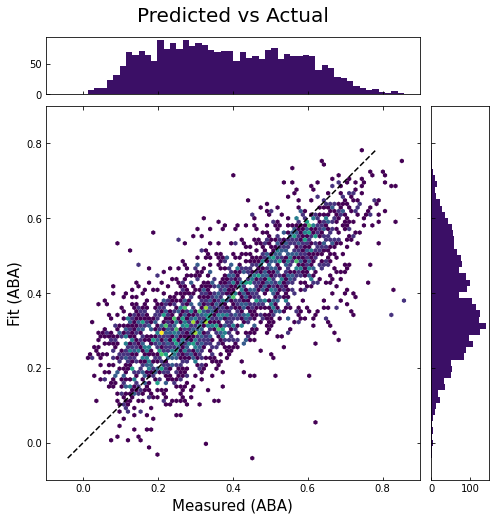

In [ ]:
fit(model, X_test, y_test)